# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.<
Simple way to demonstrate how clustering works is to simply generate some data and show clustering in action. 

In [3]:
import torch
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data (synthetic)

In [4]:
n_clusters=6
#n_samples =500
#n_samples=[250,300,75,125,500,400] # this is needed to have clusters of different size
n_samples = random.sample(range(1, 1000), n_clusters)
assert n_clusters==len(n_samples)

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate random points about it.

In [5]:
#centroids = torch.randint(-35, 35, (n_clusters, 2)).float()

centroids = torch.rand(n_clusters, 2)*70-35

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [9]:
def sample(m,n_samples): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [11]:
slices,labels = zip(*[(sample(c,s),torch.tensor([label]*s)) for label,(c,s) in enumerate(zip(centroids,n_samples))])
data = torch.cat(slices)
labels = torch.cat(labels)
data.shape, labels.shape

(torch.Size([1650, 2]), torch.Size([1650]))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [12]:
import matplotlib.pyplot as plt

In [15]:
def plot_data(centroids, data, labels, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,(c,s) in enumerate(zip(centroids,labels.unique())):
        samples = data[labels==s]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*c, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*c, markersize=5, marker="x", color='m', mew=2)

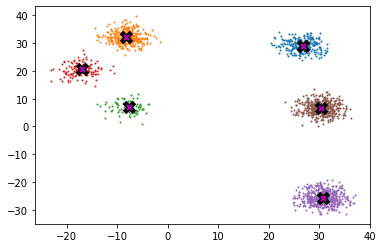

In [17]:
plot_data(centroids, data, labels)

In [18]:
midp = data.mean(0)
midp

tensor([17.552,  5.992])

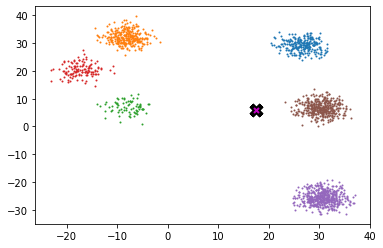

In [19]:
plot_data([midp]*6, data, labels)

## [Mean shift](https://en.wikipedia.org/wiki/Mean_shift) Algorithm

In the clustering problem the centroids are not given, we need to find them. <br>
Mean shift is a procedure for locating the maxima—the modes—of a density function given discrete data sampled from that function.

Most known clustering algorithms is **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

The definition of the gaussian kernel:
$$f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$
or 
$$g(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right)$$
Below: $$\sigma = bw $$         $$ (x - \mu) = d $$

In [20]:
import math
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

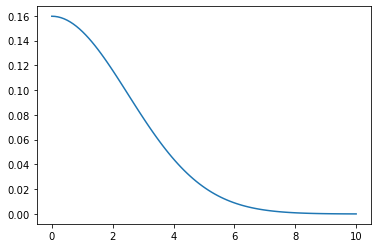

In [55]:
#x indicates the distance from a point.
x = torch.linspace(0,10,100)
plt.plot(x, gaussian(x,2.5), label='Gaussian');

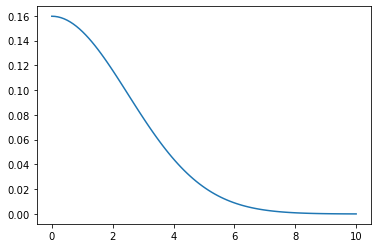

In [22]:
#Alternative using partial
from functools import partial

def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

plot_func(partial(gaussian, bw=2.5))

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data. ??

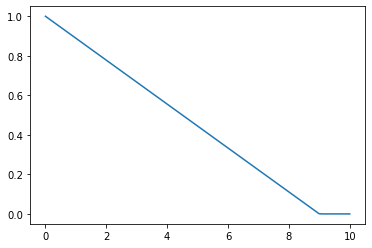

In [23]:
#Alternative function that is simpler and very similar
def tri(d, i): return (-d+i).clamp_min(0)/i
plot_func(partial(tri, i=9))

In [118]:
X = data.clone() # Data
x = data[0]  # first point
x

tensor([26.750, 29.213])

In [59]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1650, 2]))

In [60]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.570, -1.617],
        [-1.304,  0.464],
        [ 3.022,  1.044],
        [-3.069, -2.711],
        [ 2.973, -1.946],
        [ 2.535,  2.669],
        [ 1.472, -4.035]])

In [70]:
def tdist(x, X):
    return ((x-X)**2).sum(1)

In [119]:
# the distance of x to every point in X
%time dist = tdist(x, X)
dist[:8]

CPU times: user 503 µs, sys: 581 µs, total: 1.08 ms
Wall time: 725 µs


tensor([ 0.000,  2.940,  1.916, 10.224, 16.769, 12.624, 13.553, 18.449])

In [72]:
dist.shape

torch.Size([1650])

In [120]:
#TODO HW: Rewrite using torch.einsum
v = x - X
%time dist2 = torch.einsum('ij,ij->i',v,v)
dist2[:8]

CPU times: user 602 µs, sys: 861 µs, total: 1.46 ms
Wall time: 732 µs


tensor([ 0.000,  2.940,  1.916, 10.224, 16.769, 12.624, 13.553, 18.449])

In [121]:
#TODO HW: Rewrite using torch.einsum
%time dist2 = torch.einsum('ij,ij->i',(x-X),(x-X))
dist2[:8]

CPU times: user 2.12 ms, sys: 1.41 ms, total: 3.53 ms
Wall time: 1.73 ms


tensor([ 0.000,  2.940,  1.916, 10.224, 16.769, 12.624, 13.553, 18.449])

In [78]:
from fastcore.test import test_close
test_close(dist, dist2)

## Compute Weights

In [77]:
weight = gaussian(dist, 2.5)
weight

tensor([0.160, 0.080, 0.119,  ..., 0.000, 0.000, 0.000])

In [40]:
weight.shape,X.shape

(torch.Size([1650]), torch.Size([1650, 2]))

Let's take a look at how the distances and weights to the first point are distributed:

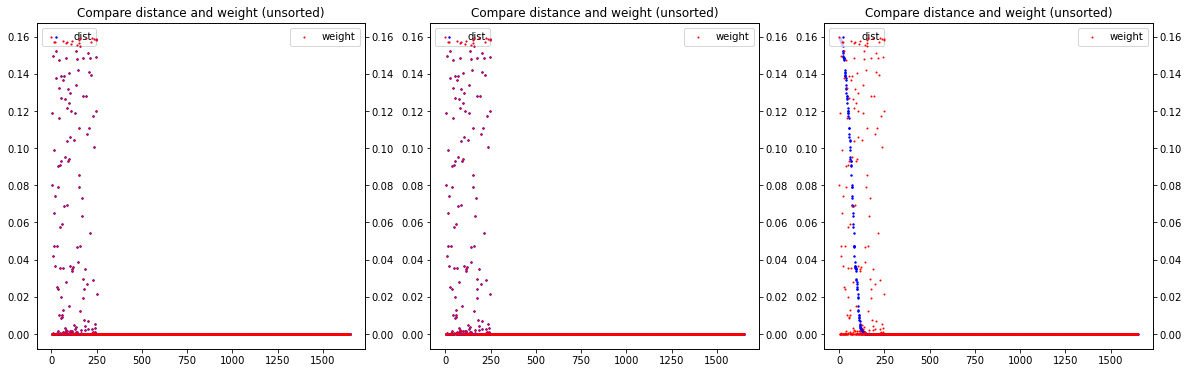

In [85]:
plt.figure(figsize=(20,6))

fs = [weight, weight[labels.argsort()], weight[dist.argsort()]]

for i in range (1,4):
    plt.subplot(1,3,i)
    plt.scatter(range(len(weight)),fs[i-1],color='b',s=2,label='dist')
    plt.legend(loc='upper left')
    plt.gca().twinx().scatter(range(len(weight)),weight,color='r',s=1,label='weight')
    plt.legend(loc='upper right')
    plt.title('Compare distance and weight (unsorted)')

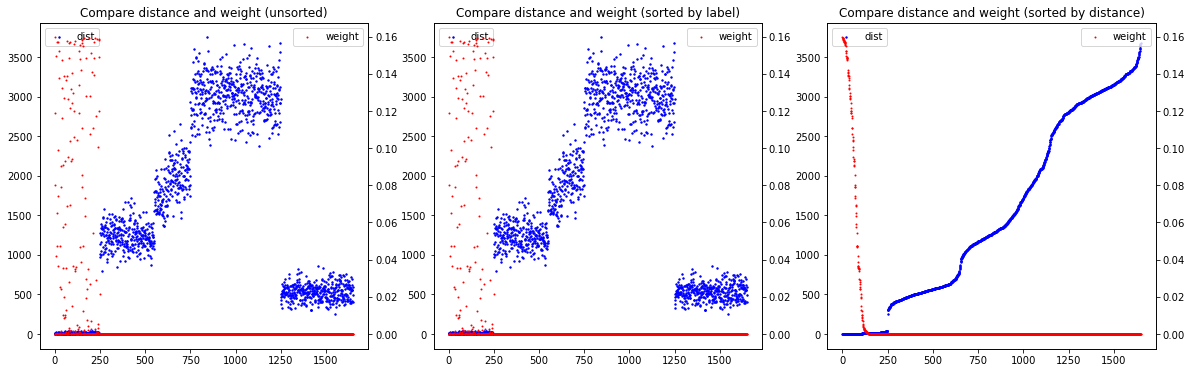

In [80]:
plt.subplot(1,3,2)
plt.scatter(range(len(weight)),dist[labels.argsort()],color='b',s=2,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[labels.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by label)')

plt.subplot(1,3,3)
plt.scatter(range(len(weight)),dist[dist.argsort()],color='b',s=2,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[dist.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by distance)');

We now want a weighted average
Formally, the weighted mean of a non-empty finite tuple of data $$\left( x_1, x_2, \dots , x_n \right)$$
with corresponding non-negative weight function|weights $$( w_1, w_2, \dots , w_n)$$ is
$$\bar{x} = \frac{ \sum\limits_{i=1}^n w_i x_i}{\sum\limits_{i=1}^n w_i}$$
which expands to:
$$\bar{x} = \frac{w_1 x_1 + w_2 x_2 + \cdots + w_n x_n}{w_1 + w_2 + \cdots + w_n}.$$

Need to add a trailing axis to the weights to be able to multiply

In [42]:
(weight[:,None]*X)

tensor([[    4.269,     4.662],
        [    3.302,     3.889],
        [    3.840,     3.936],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [43]:
(weight[:,None]*X).sum(0)/weight.sum()

tensor([26.796, 29.278])

Now all together in a single cell for a single update.

In [86]:
def one_update(X):
    for i, x in enumerate(X):
        #dist = torch.sqrt(((x-X)**2).sum(1))
        dist = torch.einsum('ij,ij->i',(x-X), (x-X)).sqrt()
        #weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [87]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [88]:
%time X=meanshift(data)

CPU times: user 5.55 s, sys: 98 ms, total: 5.65 s
Wall time: 964 ms


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

In [89]:
n_samples = labels

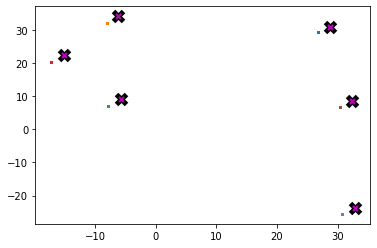

In [90]:
plot_data(centroids+2, X, labels) #n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## Animation

In [91]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [92]:
def do_one(d):
    if not d: return plot_data(centroids+2, X, n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [93]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

**Homework:**
implement [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), [dbscan](https://en.wikipedia.org/wiki/DBSCAN), 
[locality sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), 
or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. 
Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super Bonus: Invent a new meanshift algorithm which picks only the closest points to avoid quadratic time.
SB+: Publish it!


# Meanshift with bias and random sampling

In [94]:
def tri_with_bias(d, i): return (-d+i).clamp_min(0)/i + 0.0001
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [95]:
# This is more or less the same definition used in lesson 12 expect batching has been removing
def vanilla_meanshift(data):
    X = data.clone()
    for it in range(5):
        weight = tri_with_bias(dist_b(X, X), 8)
        div = weight.sum(1, keepdim=True)
        X = weight@X/div
    return X

In [97]:
n_datapoints = len(X)

In [98]:
def meanshift_with_random_sampling(data, n=5, rs=n_datapoints):
    X = data.clone()
    for it in range(5):
      rdx = torch.randint(0, X.shape[0], (rs,))
      X_rand = X[rdx] 
      dist = ((X.unsqueeze(1) - X_rand.unsqueeze(0))**2).sum(2).sqrt()
      w = tri_with_bias(dist, 8)
      w_norm = w/w.sum(1, keepdim=True)
      X = (X_rand.unsqueeze(0) * w_norm.unsqueeze(-1)).sum(1)
    return X

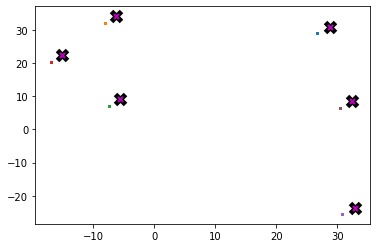

In [99]:
plot_data(centroids+2, vanilla_meanshift(data).cpu(), n_samples, ax=None)

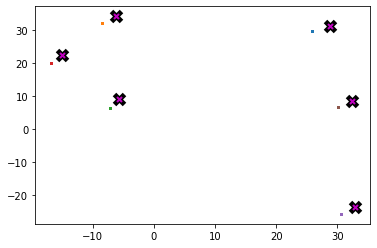

In [107]:
plot_data(centroids+2, meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints)).cpu(), n_samples, ax=None)

## Performance

In [105]:
%time vanilla_meanshift(data)

CPU times: user 982 ms, sys: 43.3 ms, total: 1.02 s
Wall time: 173 ms


tensor([[26.693, 29.153],
        [26.693, 29.153],
        [26.693, 29.153],
        ...,
        [30.340,  6.601],
        [30.340,  6.601],
        [30.340,  6.601]])

In [108]:
%time meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints))

CPU times: user 44.5 ms, sys: 2.14 ms, total: 46.6 ms
Wall time: 8.55 ms


tensor([[27.463, 29.623],
        [27.463, 29.623],
        [27.463, 29.623],
        ...,
        [29.894,  6.407],
        [29.894,  6.407],
        [29.894,  6.407]])

In [109]:
%timeit -n 5 -r 10 -o vanilla_meanshift(data) #.cpu()

181 ms ± 6.02 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 181 ms ± 6.02 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [110]:
%timeit -n 5 -r 10 -o meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints)) #.cpu()

6.95 ms ± 450 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 6.95 ms ± 450 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)>

Let's see how the performance varies based on the number of random samples k

In [112]:
n_random_samples = torch.linspace(50, n_datapoints, 30)

In [113]:
avg_run_times = []
for n in n_random_samples:
  result = %timeit -n 5 -r 100 -o meanshift_with_random_sampling(data, n=5, rs=int(n.item())).cpu()
  avg_time_in_ms = round(1000*result.average, 2)
  avg_run_times.append(avg_time_in_ms)

3.22 ms ± 794 µs per loop (mean ± std. dev. of 100 runs, 5 loops each)
4.9 ms ± 930 µs per loop (mean ± std. dev. of 100 runs, 5 loops each)
7.05 ms ± 740 µs per loop (mean ± std. dev. of 100 runs, 5 loops each)
15 ms ± 1.85 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
19.1 ms ± 1.95 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
28.1 ms ± 4.36 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
34.1 ms ± 5.55 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
36.5 ms ± 2.68 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
43.3 ms ± 10.2 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
53.4 ms ± 3.82 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
62.8 ms ± 8.43 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
66.4 ms ± 7.69 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
79.6 ms ± 9.66 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
81.3 ms ± 10.4 ms per loop (mean ± std. dev. of 100 runs, 5 loops each

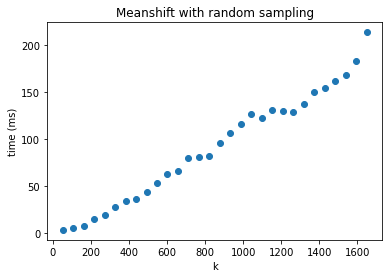

In [114]:
fig, ax = plt.subplots()
ax.scatter(n_random_samples, avg_run_times)
plt.xlabel('k')
plt.ylabel('time (ms)')
plt.title('Meanshift with random sampling')
plt.savefig('meanshift_with_random_sampling_timing_data.png')

In [76]:
STOP: no GPU

SyntaxError: invalid syntax (4015990691.py, line 1)

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [42]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [43]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

tensor([[0.6161, 0.7434, 0.7351, 0.9002, 0.5875, 0.5845, 0.2929, 0.1938],
        [1.1132, 0.2402, 0.9845, 0.4507, 1.0699, 0.6556, 0.6886, 0.7938],
        [0.0261, 0.9847, 0.3508, 1.0109, 0.0595, 0.5418, 0.4450, 0.4208],
        [0.4530, 0.8696, 0.1635, 0.7858, 0.4366, 0.4354, 0.6171, 0.7125],
        [0.6937, 0.4877, 0.4028, 0.3711, 0.6562, 0.2454, 0.5457, 0.6985]])

In [44]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[1.9947e-01, 1.5541e-01, 5.4735e-02,  ..., 2.2132e-13, 2.0775e-15,
         1.6831e-24],
        [1.5541e-01, 1.9947e-01, 1.1173e-01,  ..., 3.1427e-13, 2.0317e-15,
         9.7350e-25],
        [5.4735e-02, 1.1173e-01, 1.9947e-01,  ..., 3.5939e-16, 9.4595e-19,
         3.9723e-29],
        [7.0175e-02, 3.1377e-02, 1.8560e-02,  ..., 5.2249e-18, 3.3886e-20,
         3.0925e-30],
        [1.4180e-02, 3.1085e-03, 1.1476e-03,  ..., 8.5815e-20, 8.2003e-22,
         9.4978e-32]])

In [45]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [46]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [47]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [48]:
num/div

tensor([[-0.5274, 24.3688],
        [-1.0042, 23.6233],
        [-0.7959, 22.5723],
        [ 1.0092, 24.4519],
        [ 1.8587, 25.1916]])

In [49]:
from fastcore.all import chunked

In [50]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [51]:
data = data.cuda()

In [54]:
X = meanshift(data).cpu()

In [55]:
%timeit -n 1 X = meanshift(data).cpu()

3.25 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


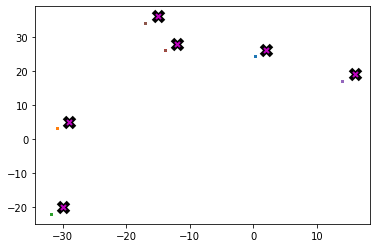

In [56]:
plot_data(centroids+2, X, n_samples)